In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.linalg import svd, expm
import time
from numpy import linalg as LA
from scipy.linalg import hadamard, subspace_angles
from numpy.linalg import matrix_rank
from scipy.linalg import expm, svd
from scipy import linalg
import math

In [50]:
# Define functions

def gen_syn_data(M, N, dim_lat, nu):
    # Extracting A and B matrices from M
    A = np.array(M)[:, 0:dim_lat]
    B = np.array(M)[:, dim_lat:dim_lat + nu]

    # System dynamics - Non-IID
    X = np.zeros((dim_lat + nu, N))
    Y = np.zeros((dim_lat, N + 1))
    sigu = 1
    sigw = 1

    rho = 5
    Sigma = rho * np.eye(dim_lat) + 2 * np.random.rand(dim_lat, dim_lat)
    Sigma_W = 0.5 * (Sigma + Sigma.T)

    Sigma_y = linalg.solve_discrete_lyapunov(A, (sigu ** 2) * np.dot(B, B.T) + Sigma_W)

    Ys = sqrtm(Sigma_y) @ np.random.normal(0, 1, (dim_lat, 1))
    Y[:,0] = Ys[:,0]

    for t in range(N):
        u = np.random.normal(0, sigu, (nu, 1))
        w = sqrtm(Sigma_W) @ np.random.normal(0, 1, (dim_lat, 1))
        X[:dim_lat, t] = Y[:, t]
        X[dim_lat:dim_lat+nu] = u
        Y_t_1 = np.dot(M, X[:, t]) + w
        Y[:, t+1] = Y_t_1[:,0]

    Y = Y[:, 1:]  # Remove the first column from Y

    return X, Y


def subspace_distance(Phi_1, Phi_2):
    r = Phi_1.shape[0]
    distance = np.sqrt(r - np.linalg.norm(Phi_1.dot(Phi_2.T), 'fro') ** 2)
    return distance


def grad_F(F,Phi,j,X,Y,lambda_F,ny,r,sigma):
    
    M = len(F)
    T = len(X)
    
    sum_term = 0
    
    for t in range(T):
        Phi_term = np.zeros([ny,r])
        Phi_term[j,:] = np.dot(Phi,X[:,t]).T
        
        sum_term = sum_term + (1/(sigma**2))*np.dot((Y[:,t] - np.dot(np.dot(F,Phi),X[:,t])).T,Phi_term)
    
    grad_weight = -(F[j,:])/(lambda_F**2) + sum_term
    
    return grad_weight


def grad_Phi(F,Phi,j,Xc,Yc,lambda_Phi,sigma):
    
    M = len(F)
    T = len(Xc)
    
    sum_term = 0
    
    for i in range(M): 
        for t in range(T):
            X = np.zeros([Xc[i][:,t].shape[0],1])
            X[:,0] = Xc[i][:,t]
            sum_term = sum_term + (1/(sigma**2))*np.dot(F[i].T,Yc[i][:,t]-np.dot(np.dot(F[i],Phi),X))*X[j,0]
    
   #Gaussian Prior
    
    #grad_phi = np.zeros([r,1])
    #grad_phi[:,0] = Phi[:,j]      
    #grad_phi=-grad_phi/(lambda_phi**2) + sum_term
    
    #Laplace Prior
    grad_phi = np.zeros([r,1])
    for i in range(r):
        if Phi[:,j][i] <= 0:
            grad_phi[i,0] = -1
        else:
            grad_phi[i,0] = 1
    

    grad_phi=-grad_phi/(lambda_phi**2) + sum_term
    return grad_phi



def CAMAP(Phi_hat, F, K, H, M, Phi_true, nx, nu, r, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi, sigma, X, Y):
    

    Error_rep = []
    Log_joint_iter = []
    l=0
    F_it = []
    Phi_hat_it=[]
    for k in range(K):
        F_it.append(F)
        Phi_hat_it.append(Phi_hat)
        
        
        start_time = time.time()
        
        # Calculating subspace distance
        Error_rep.append(subspace_distance(Phi_true, Phi_hat))
        
        
       
        Xc=[]
        Yc=[]
        
        for h in range(H): # For all tasks do
           
            for j in range(ny):
                F[h][j,:] = F[h][j,:] + eta_F*grad_F(F[h],Phi_hat,int(j),X[h],Y[h],lambda_F,ny,r,sigma)
                
        for j in range(nx):
            Phi_hat[:,j] = Phi_hat[:,j] + (eta_phi)*grad_Phi(F,Phi_hat,int(j),X,Y,lambda_phi,sigma)[:,0]
        
        eta_phi = eta_phi/1.005
    
        
        end_time = time.time()
        print(f"Iteration: {l}, Subspace Dist: {Error_rep[l]}, Time: {end_time - start_time}")
        
        
        if math.isnan(Error_rep[l]):
            Error_rep = Error_rep[:-1]
            eta_phi = eta_phi/100
            eta_F = eta_F/100
            Phi_hat = Phi_hat_it[l-1]
            F = F_it[l-1]
            break 
        else:
            l=l+1
        
        
    return Error_rep, Phi_hat, F


$\textbf{System Parameter:}$

In [60]:
nx = 4
nu = 2

r = nx + nu  # rank

dim_lat = 25  # latent space dimension

ny = dim_lat
nx = dim_lat + nu

H = 50 # number of tasks
N = 100
lambda_F = 10

# Randomly generate the true representation
Phi, _, _ = svd(np.random.randn(dim_lat + nu, dim_lat + nu))
Phi = Phi[0:r, :]


#Generating a sparse representation

Phi_true_sparse = np.zeros([Phi.shape[0],Phi.shape[1]])

for i in range(Phi.shape[0]):
    for j in range(Phi.shape[1]):
        if Phi[i,j]<=0:
            Phi_true_sparse[i,j] = 0
        else:
            Phi_true_sparse[i,j] = Phi[i,j]

Phi = Phi_true_sparse

Phi_true = Phi

# Randomly generate the nominal task weights F
F_0 = np.zeros([ny,r])

for i in range(ny):
    for j in range(r):
        F_0[i,j] = np.random.normal(loc=0, scale=lambda_F)

F_0 = F_0 / np.linalg.norm(F_0)

M_0 = np.dot(F_0, Phi)  # Nominal operator M

# Generating different tasks weights
H = 25
scale = 0.001
F = []
P = []
for h in range(H):
    L = scale * np.random.randn(dim_lat, dim_lat)
    skewL = (L - L.T) / 2
    P.append(expm(skewL))
    F.append(np.dot(P[h], F_0))

M = []
for h in range(H):
    M.append(np.dot(F[h], Phi))  # Generating the true operators M for H different tasks

In [61]:
#Initializing the representation
L = np.random.randn(dim_lat + nu, dim_lat + nu)
skewL = (L - L.T) / 2
rot = expm(skewL)

X = []
Y = []
for h in range(H):
    [X_h,Y_h] = gen_syn_data(M[h], N, dim_lat, nu)
    X.append(X_h)
    Y.append(Y_h)

$\textbf{Coordinate Ascent MAP Estimation:}$

In [10]:
K = 2500 #number of global iterations
N = 100  #number of samples

lambda_phi = 7.5
sigma = 0.06

eta_F = 1e-6
eta_phi = 0.75e-6

Phi_hat = Phi_true.dot(rot)

$\textbf{Gaussian Prior}\;\ (M = 10)$

In [11]:
H = 10
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_10_Gaussian, _, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, r, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.3680622122391997, Time: 0.17197918891906738
Iteration: 1, Subspace Dist: 2.376798335453549, Time: 0.14261865615844727
Iteration: 2, Subspace Dist: 2.3817118679259712, Time: 0.1997368335723877
Iteration: 3, Subspace Dist: 2.3847197466798544, Time: 0.139662504196167
Iteration: 4, Subspace Dist: 2.386763328259755, Time: 0.14586853981018066
Iteration: 5, Subspace Dist: 2.388338200636037, Time: 0.14008498191833496
Iteration: 6, Subspace Dist: 2.389704199546893, Time: 0.1480724811553955
Iteration: 7, Subspace Dist: 2.3909844883598272, Time: 0.14809656143188477
Iteration: 8, Subspace Dist: 2.392220772294815, Time: 0.1468346118927002
Iteration: 9, Subspace Dist: 2.3934085635985234, Time: 0.13867974281311035
Iteration: 10, Subspace Dist: 2.3945211910604725, Time: 0.14841914176940918
Iteration: 11, Subspace Dist: 2.3955256479574834, Time: 0.16198992729187012
Iteration: 12, Subspace Dist: 2.396391670754131, Time: 0.15001726150512695
Iteration: 13, Subspace Dist: 2.3

Iteration: 109, Subspace Dist: 2.2331652692212276, Time: 0.14722990989685059
Iteration: 110, Subspace Dist: 2.233305396747727, Time: 0.15043306350708008
Iteration: 111, Subspace Dist: 2.2334490820544453, Time: 0.1481783390045166
Iteration: 112, Subspace Dist: 2.233595504536345, Time: 0.14296483993530273
Iteration: 113, Subspace Dist: 2.233743899344147, Time: 0.16239452362060547
Iteration: 114, Subspace Dist: 2.2338935557608988, Time: 0.14409565925598145
Iteration: 115, Subspace Dist: 2.234043815701046, Time: 0.1536870002746582
Iteration: 116, Subspace Dist: 2.2341940723247387, Time: 0.13899469375610352
Iteration: 117, Subspace Dist: 2.2343437687571766, Time: 0.17067956924438477
Iteration: 118, Subspace Dist: 2.2344923969004142, Time: 0.1492292881011963
Iteration: 119, Subspace Dist: 2.2346394963232084, Time: 0.1429579257965088
Iteration: 120, Subspace Dist: 2.2347846532130484, Time: 0.13666987419128418
Iteration: 121, Subspace Dist: 2.2349274993734873, Time: 0.16184186935424805
Iterati

Iteration: 218, Subspace Dist: 2.2398451717796237, Time: 0.15639710426330566
Iteration: 219, Subspace Dist: 2.2396878038034926, Time: 0.15308833122253418
Iteration: 220, Subspace Dist: 2.239523981800361, Time: 0.14700007438659668
Iteration: 221, Subspace Dist: 2.239353875351485, Time: 0.15566802024841309
Iteration: 222, Subspace Dist: 2.2391776611829277, Time: 0.1441352367401123
Iteration: 223, Subspace Dist: 2.238995522528463, Time: 0.16011571884155273
Iteration: 224, Subspace Dist: 2.238807648498112, Time: 0.14561176300048828
Iteration: 225, Subspace Dist: 2.238614233454272, Time: 0.15714120864868164
Iteration: 226, Subspace Dist: 2.2384154763972424, Time: 0.1561717987060547
Iteration: 227, Subspace Dist: 2.238211580361834, Time: 0.14258623123168945
Iteration: 228, Subspace Dist: 2.23800275182662, Time: 0.14746689796447754
Iteration: 229, Subspace Dist: 2.2377892001372537, Time: 0.14853930473327637
Iteration: 230, Subspace Dist: 2.2375711369451543, Time: 0.28144097328186035
Iteration

Iteration: 326, Subspace Dist: 2.217267562918616, Time: 0.15392422676086426
Iteration: 327, Subspace Dist: 2.217148867299541, Time: 0.1473097801208496
Iteration: 328, Subspace Dist: 2.2170320278869142, Time: 0.15229582786560059
Iteration: 329, Subspace Dist: 2.2169170247079437, Time: 0.1517348289489746
Iteration: 330, Subspace Dist: 2.2168038379885977, Time: 0.15540194511413574
Iteration: 331, Subspace Dist: 2.216692448164826, Time: 0.15465402603149414
Iteration: 332, Subspace Dist: 2.2165828358924817, Time: 0.19102191925048828
Iteration: 333, Subspace Dist: 2.216474982056001, Time: 0.216841459274292
Iteration: 334, Subspace Dist: 2.216368867775915, Time: 0.16414690017700195
Iteration: 335, Subspace Dist: 2.216264474415257, Time: 0.14972853660583496
Iteration: 336, Subspace Dist: 2.216161783584931, Time: 0.15117597579956055
Iteration: 337, Subspace Dist: 2.2160607771480954, Time: 0.14688444137573242
Iteration: 338, Subspace Dist: 2.21596143722363, Time: 0.15772700309753418
Iteration: 3

Iteration: 434, Subspace Dist: 2.2122139079143244, Time: 0.29357171058654785
Iteration: 435, Subspace Dist: 2.2122192756063903, Time: 0.24232220649719238
Iteration: 436, Subspace Dist: 2.212225277561606, Time: 0.30793046951293945
Iteration: 437, Subspace Dist: 2.2122319058978714, Time: 0.15594244003295898
Iteration: 438, Subspace Dist: 2.2122391527610255, Time: 0.17358970642089844
Iteration: 439, Subspace Dist: 2.2122470103254996, Time: 0.2079458236694336
Iteration: 440, Subspace Dist: 2.2122554707949846, Time: 0.2236778736114502
Iteration: 441, Subspace Dist: 2.2122645264031013, Time: 0.1980454921722412
Iteration: 442, Subspace Dist: 2.2122741694140817, Time: 0.1666100025177002
Iteration: 443, Subspace Dist: 2.2122843921234483, Time: 0.16348505020141602
Iteration: 444, Subspace Dist: 2.212295186858701, Time: 0.16530442237854004
Iteration: 445, Subspace Dist: 2.2123065459800024, Time: 0.24401164054870605
Iteration: 446, Subspace Dist: 2.2123184618808653, Time: 0.2797553539276123
Iterat

Iteration: 542, Subspace Dist: 2.2150620445090423, Time: 0.2220315933227539
Iteration: 543, Subspace Dist: 2.215098873758532, Time: 0.20359420776367188
Iteration: 544, Subspace Dist: 2.2151357401525487, Time: 0.1787402629852295
Iteration: 545, Subspace Dist: 2.2151726407899086, Time: 0.19075870513916016
Iteration: 546, Subspace Dist: 2.2152095728111907, Time: 0.1772160530090332
Iteration: 547, Subspace Dist: 2.2152465333983833, Time: 0.171339750289917
Iteration: 548, Subspace Dist: 2.215283519774536, Time: 0.1681499481201172
Iteration: 549, Subspace Dist: 2.215320529203411, Time: 0.17680931091308594
Iteration: 550, Subspace Dist: 2.215357558989128, Time: 0.17107343673706055
Iteration: 551, Subspace Dist: 2.215394606475813, Time: 0.17801809310913086
Iteration: 552, Subspace Dist: 2.2154316690472418, Time: 0.17708754539489746
Iteration: 553, Subspace Dist: 2.215468744126488, Time: 0.1799912452697754
Iteration: 554, Subspace Dist: 2.2155058291755645, Time: 0.17366862297058105
Iteration: 5

Iteration: 650, Subspace Dist: 2.2188470800972397, Time: 0.16486358642578125
Iteration: 651, Subspace Dist: 2.218877848301466, Time: 0.14552688598632812
Iteration: 652, Subspace Dist: 2.218908513262459, Time: 0.13787317276000977
Iteration: 653, Subspace Dist: 2.2189390747416367, Time: 0.16875028610229492
Iteration: 654, Subspace Dist: 2.2189695325113954, Time: 0.21120238304138184
Iteration: 655, Subspace Dist: 2.21899988635494, Time: 0.2620837688446045
Iteration: 656, Subspace Dist: 2.219030136066116, Time: 0.24674177169799805
Iteration: 657, Subspace Dist: 2.219060281449246, Time: 0.15507721900939941
Iteration: 658, Subspace Dist: 2.219090322318959, Time: 0.14520645141601562
Iteration: 659, Subspace Dist: 2.219120258500035, Time: 0.1380305290222168
Iteration: 660, Subspace Dist: 2.21915008982724, Time: 0.1453540325164795
Iteration: 661, Subspace Dist: 2.2191798161451697, Time: 0.15717029571533203
Iteration: 662, Subspace Dist: 2.2192094373080935, Time: 0.1388859748840332
Iteration: 66

Iteration: 759, Subspace Dist: 2.2215878117009114, Time: 0.13563847541809082
Iteration: 760, Subspace Dist: 2.2216074817844875, Time: 0.1296553611755371
Iteration: 761, Subspace Dist: 2.2216270608027595, Time: 0.13161134719848633
Iteration: 762, Subspace Dist: 2.22164654904552, Time: 0.13437247276306152
Iteration: 763, Subspace Dist: 2.2216659468035687, Time: 0.1326143741607666
Iteration: 764, Subspace Dist: 2.2216852543686785, Time: 0.13463830947875977
Iteration: 765, Subspace Dist: 2.2217044720335566, Time: 0.13563776016235352
Iteration: 766, Subspace Dist: 2.221723600091809, Time: 0.1356360912322998
Iteration: 767, Subspace Dist: 2.2217426388379047, Time: 0.1326451301574707
Iteration: 768, Subspace Dist: 2.22176158856714, Time: 0.13563799858093262
Iteration: 769, Subspace Dist: 2.221780449575602, Time: 0.13862872123718262
Iteration: 770, Subspace Dist: 2.2217992221601395, Time: 0.13467764854431152
Iteration: 771, Subspace Dist: 2.2218179066183237, Time: 0.13659143447875977
Iteration

Iteration: 867, Subspace Dist: 2.2232473357798535, Time: 0.18051648139953613
Iteration: 868, Subspace Dist: 2.223258903414427, Time: 0.22140741348266602
Iteration: 869, Subspace Dist: 2.2232704119061903, Time: 0.13563823699951172
Iteration: 870, Subspace Dist: 2.223281861524914, Time: 0.13763093948364258
Iteration: 871, Subspace Dist: 2.2232932525395612, Time: 0.1356372833251953
Iteration: 872, Subspace Dist: 2.2233045852182833, Time: 0.137664794921875
Iteration: 873, Subspace Dist: 2.2233158598284164, Time: 0.18165111541748047
Iteration: 874, Subspace Dist: 2.2233270766364766, Time: 0.22440218925476074
Iteration: 875, Subspace Dist: 2.2233382359081584, Time: 0.13463973999023438
Iteration: 876, Subspace Dist: 2.22334933790833, Time: 0.14162111282348633
Iteration: 877, Subspace Dist: 2.2233603829010296, Time: 0.14461159706115723
Iteration: 878, Subspace Dist: 2.2233713711494625, Time: 0.13663625717163086
Iteration: 879, Subspace Dist: 2.2233823029159985, Time: 0.13663315773010254
Iterat

Iteration: 975, Subspace Dist: 2.2242054134698814, Time: 0.1662907600402832
Iteration: 976, Subspace Dist: 2.2242119772403544, Time: 0.14465808868408203
Iteration: 977, Subspace Dist: 2.22421850602755, Time: 0.16141915321350098
Iteration: 978, Subspace Dist: 2.224225000008747, Time: 0.1668405532836914
Iteration: 979, Subspace Dist: 2.224231459360423, Time: 0.14945602416992188
Iteration: 980, Subspace Dist: 2.224237884258265, Time: 0.15843415260314941
Iteration: 981, Subspace Dist: 2.224244274877162, Time: 0.18592214584350586
Iteration: 982, Subspace Dist: 2.224250631391216, Time: 0.16635346412658691
Iteration: 983, Subspace Dist: 2.2242569539737382, Time: 0.158095121383667
Iteration: 984, Subspace Dist: 2.2242632427972553, Time: 0.13774347305297852
Iteration: 985, Subspace Dist: 2.224269498033508, Time: 0.14951276779174805
Iteration: 986, Subspace Dist: 2.224275719853457, Time: 0.1588296890258789
Iteration: 987, Subspace Dist: 2.2242819084272836, Time: 0.14062714576721191
Iteration: 98

Iteration: 1082, Subspace Dist: 2.2247406736330335, Time: 0.15895962715148926
Iteration: 1083, Subspace Dist: 2.224744353751241, Time: 0.14616012573242188
Iteration: 1084, Subspace Dist: 2.2247480138179716, Time: 0.15690350532531738
Iteration: 1085, Subspace Dist: 2.2247516539391845, Time: 0.15344810485839844
Iteration: 1086, Subspace Dist: 2.224755274220307, Time: 0.2323160171508789
Iteration: 1087, Subspace Dist: 2.2247588747662363, Time: 0.17397856712341309
Iteration: 1088, Subspace Dist: 2.224762455681343, Time: 0.15874147415161133
Iteration: 1089, Subspace Dist: 2.2247660170694727, Time: 0.15024232864379883
Iteration: 1090, Subspace Dist: 2.2247695590339482, Time: 0.22181963920593262
Iteration: 1091, Subspace Dist: 2.224773081677572, Time: 0.16019105911254883
Iteration: 1092, Subspace Dist: 2.2247765851026293, Time: 0.15120625495910645
Iteration: 1093, Subspace Dist: 2.2247800694108886, Time: 0.162153959274292
Iteration: 1094, Subspace Dist: 2.224783534703607, Time: 0.154798507690

Iteration: 1190, Subspace Dist: 2.225041300630783, Time: 0.2580287456512451
Iteration: 1191, Subspace Dist: 2.2250433307126984, Time: 0.2437586784362793
Iteration: 1192, Subspace Dist: 2.2250453495581364, Time: 0.19455337524414062
Iteration: 1193, Subspace Dist: 2.225047357227818, Time: 0.22445893287658691
Iteration: 1194, Subspace Dist: 2.2250493537821474, Time: 0.1835944652557373
Iteration: 1195, Subspace Dist: 2.2250513392812117, Time: 0.28403186798095703
Iteration: 1196, Subspace Dist: 2.225053313784783, Time: 0.17551016807556152
Iteration: 1197, Subspace Dist: 2.2250552773523204, Time: 0.28794407844543457
Iteration: 1198, Subspace Dist: 2.2250572300429714, Time: 0.17857122421264648
Iteration: 1199, Subspace Dist: 2.225059171915573, Time: 0.17439961433410645
Iteration: 1200, Subspace Dist: 2.2250611030286525, Time: 0.16108489036560059
Iteration: 1201, Subspace Dist: 2.2250630234404327, Time: 0.21593737602233887
Iteration: 1202, Subspace Dist: 2.2250649332088286, Time: 0.17445135116

Iteration: 1298, Subspace Dist: 2.2252064810698506, Time: 0.14202070236206055
Iteration: 1299, Subspace Dist: 2.2252075912767513, Time: 0.15134072303771973
Iteration: 1300, Subspace Dist: 2.2252086952555294, Time: 0.13924908638000488
Iteration: 1301, Subspace Dist: 2.2252097930403893, Time: 0.14816951751708984
Iteration: 1302, Subspace Dist: 2.2252108846653536, Time: 0.13863658905029297
Iteration: 1303, Subspace Dist: 2.2252119701642603, Time: 0.15362858772277832
Iteration: 1304, Subspace Dist: 2.2252130495707685, Time: 0.19612860679626465
Iteration: 1305, Subspace Dist: 2.2252141229183557, Time: 0.20919275283813477
Iteration: 1306, Subspace Dist: 2.2252151902403203, Time: 0.27443480491638184
Iteration: 1307, Subspace Dist: 2.2252162515697824, Time: 0.3010444641113281
Iteration: 1308, Subspace Dist: 2.2252173069396837, Time: 0.28068065643310547
Iteration: 1309, Subspace Dist: 2.2252183563827903, Time: 0.398698091506958
Iteration: 1310, Subspace Dist: 2.2252193999316923, Time: 0.1885755

Iteration: 1404, Subspace Dist: 2.225295281074109, Time: 0.144761323928833
Iteration: 1405, Subspace Dist: 2.2252958903889333, Time: 0.13377094268798828
Iteration: 1406, Subspace Dist: 2.2252964962439368, Time: 0.14382457733154297
Iteration: 1407, Subspace Dist: 2.2252970986583858, Time: 0.13966155052185059
Iteration: 1408, Subspace Dist: 2.2252976976514423, Time: 0.14186573028564453
Iteration: 1409, Subspace Dist: 2.225298293242165, Time: 0.13482213020324707
Iteration: 1410, Subspace Dist: 2.2252988854495066, Time: 0.1447286605834961
Iteration: 1411, Subspace Dist: 2.225299474292319, Time: 0.1342144012451172
Iteration: 1412, Subspace Dist: 2.225300059789349, Time: 0.14549493789672852
Iteration: 1413, Subspace Dist: 2.2253006419592434, Time: 0.1413881778717041
Iteration: 1414, Subspace Dist: 2.225301220820546, Time: 0.14491629600524902
Iteration: 1415, Subspace Dist: 2.2253017963916997, Time: 0.13631176948547363
Iteration: 1416, Subspace Dist: 2.2253023686910485, Time: 0.1444091796875


Iteration: 1511, Subspace Dist: 2.225344194333847, Time: 0.16057610511779785
Iteration: 1512, Subspace Dist: 2.2253445244820615, Time: 0.13783526420593262
Iteration: 1513, Subspace Dist: 2.225344852734223, Time: 0.16688084602355957
Iteration: 1514, Subspace Dist: 2.2253451791010286, Time: 0.17218637466430664
Iteration: 1515, Subspace Dist: 2.225345503593116, Time: 0.14879870414733887
Iteration: 1516, Subspace Dist: 2.2253458262210644, Time: 0.14047980308532715
Iteration: 1517, Subspace Dist: 2.225346146995394, Time: 0.17387604713439941
Iteration: 1518, Subspace Dist: 2.225346465926567, Time: 0.16850757598876953
Iteration: 1519, Subspace Dist: 2.2253467830249885, Time: 0.15532255172729492
Iteration: 1520, Subspace Dist: 2.225347098301005, Time: 0.1367511749267578
Iteration: 1521, Subspace Dist: 2.225347411764906, Time: 0.14336490631103516
Iteration: 1522, Subspace Dist: 2.2253477234269248, Time: 0.13791561126708984
Iteration: 1523, Subspace Dist: 2.2253480332972373, Time: 0.153880357742

Iteration: 1619, Subspace Dist: 2.2253707945962984, Time: 0.16266679763793945
Iteration: 1620, Subspace Dist: 2.2253709712482213, Time: 0.15274834632873535
Iteration: 1621, Subspace Dist: 2.2253711468748474, Time: 0.15208148956298828
Iteration: 1622, Subspace Dist: 2.225371321482032, Time: 0.1565685272216797
Iteration: 1623, Subspace Dist: 2.225371495075598, Time: 0.1497211456298828
Iteration: 1624, Subspace Dist: 2.225371667661335, Time: 0.15625524520874023
Iteration: 1625, Subspace Dist: 2.2253718392450006, Time: 0.14752697944641113
Iteration: 1626, Subspace Dist: 2.225372009832321, Time: 0.15199494361877441
Iteration: 1627, Subspace Dist: 2.225372179428988, Time: 0.15759587287902832
Iteration: 1628, Subspace Dist: 2.2253723480406635, Time: 0.15047883987426758
Iteration: 1629, Subspace Dist: 2.225372515672977, Time: 0.15047717094421387
Iteration: 1630, Subspace Dist: 2.225372682331527, Time: 0.14663171768188477
Iteration: 1631, Subspace Dist: 2.225372848021879, Time: 0.15445804595947

Iteration: 1725, Subspace Dist: 2.2253847972717264, Time: 0.34493088722229004
Iteration: 1726, Subspace Dist: 2.225384892302128, Time: 0.2539224624633789
Iteration: 1727, Subspace Dist: 2.2253849867757105, Time: 0.17136812210083008
Iteration: 1728, Subspace Dist: 2.2253850806956894, Time: 0.15204954147338867
Iteration: 1729, Subspace Dist: 2.2253851740652615, Time: 0.1515638828277588
Iteration: 1730, Subspace Dist: 2.2253852668876064, Time: 0.15859246253967285
Iteration: 1731, Subspace Dist: 2.2253853591658848, Time: 0.16866350173950195
Iteration: 1732, Subspace Dist: 2.225385450903239, Time: 0.17311859130859375
Iteration: 1733, Subspace Dist: 2.2253855421027953, Time: 0.1405482292175293
Iteration: 1734, Subspace Dist: 2.2253856327676607, Time: 0.14226579666137695
Iteration: 1735, Subspace Dist: 2.225385722900924, Time: 0.14988136291503906
Iteration: 1736, Subspace Dist: 2.225385812505659, Time: 0.139801025390625
Iteration: 1737, Subspace Dist: 2.2253859015849193, Time: 0.1441993713378

Iteration: 1832, Subspace Dist: 2.225392361700625, Time: 0.1508793830871582
Iteration: 1833, Subspace Dist: 2.22539241223381, Time: 0.1503617763519287
Iteration: 1834, Subspace Dist: 2.2253924624683177, Time: 0.1606123447418213
Iteration: 1835, Subspace Dist: 2.2253925124058904, Time: 0.15552377700805664
Iteration: 1836, Subspace Dist: 2.2253925620482606, Time: 0.15967535972595215
Iteration: 1837, Subspace Dist: 2.2253926113971505, Time: 0.17558646202087402
Iteration: 1838, Subspace Dist: 2.2253926604542724, Time: 0.16699886322021484
Iteration: 1839, Subspace Dist: 2.22539270922133, Time: 0.1781461238861084
Iteration: 1840, Subspace Dist: 2.2253927577000154, Time: 0.21377205848693848
Iteration: 1841, Subspace Dist: 2.2253928058920125, Time: 0.15625977516174316
Iteration: 1842, Subspace Dist: 2.225392853798994, Time: 0.1625957489013672
Iteration: 1843, Subspace Dist: 2.225392901422625, Time: 0.16764235496520996
Iteration: 1844, Subspace Dist: 2.2253929487645587, Time: 0.1675145626068115

Iteration: 1939, Subspace Dist: 2.225396374631175, Time: 0.13766169548034668
Iteration: 1940, Subspace Dist: 2.225396401361784, Time: 0.13361215591430664
Iteration: 1941, Subspace Dist: 2.2253964279331595, Time: 0.14162206649780273
Iteration: 1942, Subspace Dist: 2.225396454346239, Time: 0.13866066932678223
Iteration: 1943, Subspace Dist: 2.225396480601954, Time: 0.13763070106506348
Iteration: 1944, Subspace Dist: 2.2253965067012316, Time: 0.13663911819458008
Iteration: 1945, Subspace Dist: 2.2253965326449934, Time: 0.14061951637268066
Iteration: 1946, Subspace Dist: 2.225396558434155, Time: 0.13939452171325684
Iteration: 1947, Subspace Dist: 2.2253965840696273, Time: 0.13962674140930176
Iteration: 1948, Subspace Dist: 2.2253966095523157, Time: 0.14162278175354004
Iteration: 1949, Subspace Dist: 2.2253966348831202, Time: 0.20145964622497559
Iteration: 1950, Subspace Dist: 2.225396660062936, Time: 0.13862943649291992
Iteration: 1951, Subspace Dist: 2.225396685092652, Time: 0.13663458824

Iteration: 2045, Subspace Dist: 2.2253984786494145, Time: 0.44354987144470215
Iteration: 2046, Subspace Dist: 2.225398492806933, Time: 0.25963473320007324
Iteration: 2047, Subspace Dist: 2.2253985068795257, Time: 0.43788981437683105
Iteration: 2048, Subspace Dist: 2.2253985208676985, Time: 0.30796289443969727
Iteration: 2049, Subspace Dist: 2.225398534771951, Time: 0.4511723518371582
Iteration: 2050, Subspace Dist: 2.225398548592783, Time: 0.2632629871368408
Iteration: 2051, Subspace Dist: 2.2253985623306884, Time: 0.2106473445892334
Iteration: 2052, Subspace Dist: 2.2253985759861608, Time: 0.35480427742004395
Iteration: 2053, Subspace Dist: 2.2253985895596893, Time: 0.23658442497253418
Iteration: 2054, Subspace Dist: 2.2253986030517607, Time: 0.24264788627624512
Iteration: 2055, Subspace Dist: 2.2253986164628587, Time: 0.2640562057495117
Iteration: 2056, Subspace Dist: 2.2253986297934647, Time: 0.2357780933380127
Iteration: 2057, Subspace Dist: 2.2253986430440564, Time: 0.230191707611

Iteration: 2152, Subspace Dist: 2.2253995983652453, Time: 0.15486860275268555
Iteration: 2153, Subspace Dist: 2.225399605786985, Time: 0.17022109031677246
Iteration: 2154, Subspace Dist: 2.2253996131639244, Time: 0.153062105178833
Iteration: 2155, Subspace Dist: 2.225399620496331, Time: 0.1537332534790039
Iteration: 2156, Subspace Dist: 2.225399627784472, Time: 0.15189218521118164
Iteration: 2157, Subspace Dist: 2.2253996350286114, Time: 0.15400028228759766
Iteration: 2158, Subspace Dist: 2.2253996422290125, Time: 0.15023207664489746
Iteration: 2159, Subspace Dist: 2.225399649385938, Time: 0.1531221866607666
Iteration: 2160, Subspace Dist: 2.2253996564996466, Time: 0.17116427421569824
Iteration: 2161, Subspace Dist: 2.2253996635703976, Time: 0.19173622131347656
Iteration: 2162, Subspace Dist: 2.2253996705984487, Time: 0.17692136764526367
Iteration: 2163, Subspace Dist: 2.225399677584054, Time: 0.15918183326721191
Iteration: 2164, Subspace Dist: 2.2253996845274684, Time: 0.1687862873077

Iteration: 2259, Subspace Dist: 2.2254001843292666, Time: 0.18862557411193848
Iteration: 2260, Subspace Dist: 2.225400188204945, Time: 0.1773548126220703
Iteration: 2261, Subspace Dist: 2.225400192057097, Time: 0.18706536293029785
Iteration: 2262, Subspace Dist: 2.2254001958858636, Time: 0.17526721954345703
Iteration: 2263, Subspace Dist: 2.2254001996913866, Time: 0.2372114658355713
Iteration: 2264, Subspace Dist: 2.225400203473805, Time: 0.1756727695465088
Iteration: 2265, Subspace Dist: 2.225400207233258, Time: 0.16851520538330078
Iteration: 2266, Subspace Dist: 2.225400210969885, Time: 0.15938854217529297
Iteration: 2267, Subspace Dist: 2.2254002146838228, Time: 0.15250539779663086
Iteration: 2268, Subspace Dist: 2.2254002183752077, Time: 0.24096918106079102
Iteration: 2269, Subspace Dist: 2.2254002220441755, Time: 0.16401028633117676
Iteration: 2270, Subspace Dist: 2.225400225690862, Time: 0.164107084274292
Iteration: 2271, Subspace Dist: 2.225400229315401, Time: 0.1713533401489257

Iteration: 2366, Subspace Dist: 2.2254004898460003, Time: 0.21754908561706543
Iteration: 2367, Subspace Dist: 2.2254004918628993, Time: 0.15003299713134766
Iteration: 2368, Subspace Dist: 2.225400493867494, Time: 0.17089462280273438
Iteration: 2369, Subspace Dist: 2.2254004958598586, Time: 0.14715957641601562
Iteration: 2370, Subspace Dist: 2.225400497840067, Time: 0.15531611442565918
Iteration: 2371, Subspace Dist: 2.2254004998081927, Time: 0.15397024154663086
Iteration: 2372, Subspace Dist: 2.2254005017643093, Time: 0.15275263786315918
Iteration: 2373, Subspace Dist: 2.225400503708489, Time: 0.16994619369506836
Iteration: 2374, Subspace Dist: 2.2254005056408053, Time: 0.18370676040649414
Iteration: 2375, Subspace Dist: 2.2254005075613286, Time: 0.15215325355529785
Iteration: 2376, Subspace Dist: 2.2254005094701315, Time: 0.14898157119750977
Iteration: 2377, Subspace Dist: 2.225400511367284, Time: 0.15255260467529297
Iteration: 2378, Subspace Dist: 2.225400513252857, Time: 0.162670850

Iteration: 2472, Subspace Dist: 2.225400647561195, Time: 0.15690135955810547
Iteration: 2473, Subspace Dist: 2.225400648613975, Time: 0.13999438285827637
Iteration: 2474, Subspace Dist: 2.2254006496603043, Time: 0.16485309600830078
Iteration: 2475, Subspace Dist: 2.225400650700221, Time: 0.14255499839782715
Iteration: 2476, Subspace Dist: 2.225400651733765, Time: 0.15057682991027832
Iteration: 2477, Subspace Dist: 2.2254006527609738, Time: 0.14908599853515625
Iteration: 2478, Subspace Dist: 2.225400653781888, Time: 0.15320181846618652
Iteration: 2479, Subspace Dist: 2.2254006547965437, Time: 0.15131258964538574
Iteration: 2480, Subspace Dist: 2.225400655804981, Time: 0.13982295989990234
Iteration: 2481, Subspace Dist: 2.225400656807237, Time: 0.14111733436584473
Iteration: 2482, Subspace Dist: 2.2254006578033487, Time: 0.15149617195129395
Iteration: 2483, Subspace Dist: 2.2254006587933546, Time: 0.13673949241638184
Iteration: 2484, Subspace Dist: 2.225400659777291, Time: 0.152638912200

$\textbf{Laplace Prior}\;\ (M = 10)$

In [77]:
lambda_phi = 7.5
sigma = 0.06

eta_F = 1e-6
eta_phi = 0.193e-6

H = 10
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP_10_Laplace, Phi_MAP, _ = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, r, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data)

Iteration: 0, Subspace Dist: 2.4018211246604415, Time: 0.1556398868560791
Iteration: 1, Subspace Dist: 2.369087254506281, Time: 0.14004850387573242
Iteration: 2, Subspace Dist: 2.397977176279945, Time: 0.23591113090515137
Iteration: 3, Subspace Dist: 2.4148903326249185, Time: 0.13352727890014648
Iteration: 4, Subspace Dist: 2.420187952465733, Time: 0.14898276329040527
Iteration: 5, Subspace Dist: 2.418696403387976, Time: 0.1463005542755127
Iteration: 6, Subspace Dist: 2.4155364246612754, Time: 0.1550135612487793
Iteration: 7, Subspace Dist: 2.4095977184236994, Time: 0.1401677131652832
Iteration: 8, Subspace Dist: 2.402780538820088, Time: 0.1572730541229248
Iteration: 9, Subspace Dist: 2.3952898705721015, Time: 0.16180682182312012
Iteration: 10, Subspace Dist: 2.3876892625553148, Time: 0.22087764739990234
Iteration: 11, Subspace Dist: 2.3802825394506986, Time: 0.15095138549804688
Iteration: 12, Subspace Dist: 2.3733058620860716, Time: 0.15981101989746094
Iteration: 13, Subspace Dist: 2.

Iteration: 110, Subspace Dist: 1.9966348848900013, Time: 0.15741467475891113
Iteration: 111, Subspace Dist: 1.9923028218351768, Time: 0.19338035583496094
Iteration: 112, Subspace Dist: 1.9879676480640682, Time: 0.16649770736694336
Iteration: 113, Subspace Dist: 1.9836295981045697, Time: 0.1618049144744873
Iteration: 114, Subspace Dist: 1.979288906639804, Time: 0.18422579765319824
Iteration: 115, Subspace Dist: 1.9749458087445237, Time: 0.1504957675933838
Iteration: 116, Subspace Dist: 1.9706005394959902, Time: 0.15710830688476562
Iteration: 117, Subspace Dist: 1.9662533341126087, Time: 0.15054988861083984
Iteration: 118, Subspace Dist: 1.9619044275146105, Time: 0.2105410099029541
Iteration: 119, Subspace Dist: 1.9575540542862073, Time: 0.18761777877807617
Iteration: 120, Subspace Dist: 1.9532024484264952, Time: 0.15761423110961914
Iteration: 121, Subspace Dist: 1.948849843127899, Time: 0.26013636589050293
Iteration: 122, Subspace Dist: 1.9444964704571546, Time: 0.19858980178833008
Iter

Iteration: 219, Subspace Dist: 1.5413734396655612, Time: 0.1490497589111328
Iteration: 220, Subspace Dist: 1.5375249538801792, Time: 0.14114832878112793
Iteration: 221, Subspace Dist: 1.533683674591881, Time: 0.14501619338989258
Iteration: 222, Subspace Dist: 1.5298496196796063, Time: 0.13640785217285156
Iteration: 223, Subspace Dist: 1.5260228067371884, Time: 0.14101600646972656
Iteration: 224, Subspace Dist: 1.522203253171345, Time: 0.13966608047485352
Iteration: 225, Subspace Dist: 1.5183909761740402, Time: 0.1447010040283203
Iteration: 226, Subspace Dist: 1.514585992694068, Time: 0.14934659004211426
Iteration: 227, Subspace Dist: 1.5107883195016976, Time: 0.1487581729888916
Iteration: 228, Subspace Dist: 1.5069979728799914, Time: 0.138047456741333
Iteration: 229, Subspace Dist: 1.5032149688692678, Time: 0.14399933815002441
Iteration: 230, Subspace Dist: 1.4994393231462433, Time: 0.13668370246887207
Iteration: 231, Subspace Dist: 1.4956710509920037, Time: 0.14708781242370605
Iterati

Iteration: 328, Subspace Dist: 1.164441468508454, Time: 0.1981348991394043
Iteration: 329, Subspace Dist: 1.161343039925806, Time: 0.21771931648254395
Iteration: 330, Subspace Dist: 1.158250183389003, Time: 0.17222261428833008
Iteration: 331, Subspace Dist: 1.1551628896860262, Time: 0.16558408737182617
Iteration: 332, Subspace Dist: 1.152081151229128, Time: 0.15433049201965332
Iteration: 333, Subspace Dist: 1.1490049619722744, Time: 0.15482139587402344
Iteration: 334, Subspace Dist: 1.1459343171747964, Time: 0.16691231727600098
Iteration: 335, Subspace Dist: 1.1428692136465284, Time: 0.16492438316345215
Iteration: 336, Subspace Dist: 1.1398096496710648, Time: 0.15140056610107422
Iteration: 337, Subspace Dist: 1.1367556250058664, Time: 0.15062475204467773
Iteration: 338, Subspace Dist: 1.1337071408799675, Time: 0.17213177680969238
Iteration: 339, Subspace Dist: 1.1306641994129805, Time: 0.1599264144897461
Iteration: 340, Subspace Dist: 1.127626805340467, Time: 0.1334998607635498
Iterati

Iteration: 437, Subspace Dist: 0.8634445107813962, Time: 0.1461939811706543
Iteration: 438, Subspace Dist: 0.8610841480728554, Time: 0.13988828659057617
Iteration: 439, Subspace Dist: 0.8587318933798406, Time: 0.14858460426330566
Iteration: 440, Subspace Dist: 0.8563877509594239, Time: 0.13729572296142578
Iteration: 441, Subspace Dist: 0.854051724353606, Time: 0.14689993858337402
Iteration: 442, Subspace Dist: 0.8517238163964421, Time: 0.1386106014251709
Iteration: 443, Subspace Dist: 0.8494040292555521, Time: 0.1462690830230713
Iteration: 444, Subspace Dist: 0.8470923642439431, Time: 0.13727545738220215
Iteration: 445, Subspace Dist: 0.8447888222120958, Time: 0.14557552337646484
Iteration: 446, Subspace Dist: 0.8424934032382151, Time: 0.13742947578430176
Iteration: 447, Subspace Dist: 0.8402061067318933, Time: 0.1454780101776123
Iteration: 448, Subspace Dist: 0.8379269314526222, Time: 0.13620448112487793
Iteration: 449, Subspace Dist: 0.8356558754870075, Time: 0.14679169654846191
Iter

Iteration: 544, Subspace Dist: 0.6549465860083943, Time: 0.14780497550964355
Iteration: 545, Subspace Dist: 0.6533807645266784, Time: 0.13898158073425293
Iteration: 546, Subspace Dist: 0.6518211439979696, Time: 0.14751958847045898
Iteration: 547, Subspace Dist: 0.6502676981319399, Time: 0.14237284660339355
Iteration: 548, Subspace Dist: 0.6487204006652256, Time: 0.1496131420135498
Iteration: 549, Subspace Dist: 0.6471792253642168, Time: 0.14029526710510254
Iteration: 550, Subspace Dist: 0.6456441460278006, Time: 0.14765548706054688
Iteration: 551, Subspace Dist: 0.6441151364900226, Time: 0.14081668853759766
Iteration: 552, Subspace Dist: 0.6425921706413864, Time: 0.14327454566955566
Iteration: 553, Subspace Dist: 0.6410752223750118, Time: 0.13546085357666016
Iteration: 554, Subspace Dist: 0.6395642655747948, Time: 0.1446685791015625
Iteration: 555, Subspace Dist: 0.6380592743123129, Time: 0.13825607299804688
Iteration: 556, Subspace Dist: 0.6365602226352306, Time: 0.14567184448242188
I

Iteration: 652, Subspace Dist: 0.5166526419425771, Time: 0.15021181106567383
Iteration: 653, Subspace Dist: 0.5156193047855715, Time: 0.13715147972106934
Iteration: 654, Subspace Dist: 0.5145897905393043, Time: 0.1453990936279297
Iteration: 655, Subspace Dist: 0.5135640826195726, Time: 0.13933920860290527
Iteration: 656, Subspace Dist: 0.5125421645389882, Time: 0.14395761489868164
Iteration: 657, Subspace Dist: 0.5115240199065072, Time: 0.13730549812316895
Iteration: 658, Subspace Dist: 0.5105096323912509, Time: 0.14476609230041504
Iteration: 659, Subspace Dist: 0.5094989858296647, Time: 0.1402897834777832
Iteration: 660, Subspace Dist: 0.5084920641171086, Time: 0.15070533752441406
Iteration: 661, Subspace Dist: 0.5074888512431721, Time: 0.1412947177886963
Iteration: 662, Subspace Dist: 0.5064893312916678, Time: 0.15080547332763672
Iteration: 663, Subspace Dist: 0.5054934884398973, Time: 0.13704133033752441
Iteration: 664, Subspace Dist: 0.5045013069582561, Time: 0.14002585411071777
It

Iteration: 760, Subspace Dist: 0.4242183848795386, Time: 0.14692926406860352
Iteration: 761, Subspace Dist: 0.4235191722002192, Time: 0.13675475120544434
Iteration: 762, Subspace Dist: 0.422822447986285, Time: 0.145308256149292
Iteration: 763, Subspace Dist: 0.42212820322566985, Time: 0.13653802871704102
Iteration: 764, Subspace Dist: 0.4214364289516429, Time: 0.1436328887939453
Iteration: 765, Subspace Dist: 0.42074711624245315, Time: 0.13556241989135742
Iteration: 766, Subspace Dist: 0.42006025622096105, Time: 0.14357233047485352
Iteration: 767, Subspace Dist: 0.41937584005429934, Time: 0.13690423965454102
Iteration: 768, Subspace Dist: 0.41869385895350403, Time: 0.14440464973449707
Iteration: 769, Subspace Dist: 0.4180143041731832, Time: 0.13645362854003906
Iteration: 770, Subspace Dist: 0.4173371670111586, Time: 0.14766192436218262
Iteration: 771, Subspace Dist: 0.4166624388081227, Time: 0.13735651969909668
Iteration: 772, Subspace Dist: 0.4159901109473232, Time: 0.1460692882537841

Iteration: 868, Subspace Dist: 0.36145002545428356, Time: 0.14241671562194824
Iteration: 869, Subspace Dist: 0.36097512516530994, Time: 0.13711929321289062
Iteration: 870, Subspace Dist: 0.3605019427825023, Time: 0.14636659622192383
Iteration: 871, Subspace Dist: 0.3600304726367016, Time: 0.13919329643249512
Iteration: 872, Subspace Dist: 0.3595607090792319, Time: 0.14222002029418945
Iteration: 873, Subspace Dist: 0.3590926464818111, Time: 0.13259649276733398
Iteration: 874, Subspace Dist: 0.35862627923639295, Time: 0.14657926559448242
Iteration: 875, Subspace Dist: 0.3581616017550436, Time: 0.1338193416595459
Iteration: 876, Subspace Dist: 0.35769860846983365, Time: 0.14611196517944336
Iteration: 877, Subspace Dist: 0.3572372938326851, Time: 0.1341555118560791
Iteration: 878, Subspace Dist: 0.3567776523152826, Time: 0.1431128978729248
Iteration: 879, Subspace Dist: 0.3563196784089155, Time: 0.13733673095703125
Iteration: 880, Subspace Dist: 0.35586336662437246, Time: 0.141878128051757

Iteration: 975, Subspace Dist: 0.31934670661750897, Time: 0.14664459228515625
Iteration: 976, Subspace Dist: 0.3190269871154819, Time: 0.13913822174072266
Iteration: 977, Subspace Dist: 0.3187084748288345, Time: 0.15020227432250977
Iteration: 978, Subspace Dist: 0.3183911657439176, Time: 0.1387791633605957
Iteration: 979, Subspace Dist: 0.31807505585889945, Time: 0.14705872535705566
Iteration: 980, Subspace Dist: 0.3177601412023526, Time: 0.13537240028381348
Iteration: 981, Subspace Dist: 0.317446417777277, Time: 0.1430361270904541
Iteration: 982, Subspace Dist: 0.31713388161704686, Time: 0.13849830627441406
Iteration: 983, Subspace Dist: 0.31682252876666883, Time: 0.14314723014831543
Iteration: 984, Subspace Dist: 0.31651235528275223, Time: 0.1371135711669922
Iteration: 985, Subspace Dist: 0.31620335723344933, Time: 0.16820454597473145
Iteration: 986, Subspace Dist: 0.31589553069842363, Time: 0.1370840072631836
Iteration: 987, Subspace Dist: 0.31558887176879347, Time: 0.14415836334228

Iteration: 1081, Subspace Dist: 0.29145492017042335, Time: 0.15029525756835938
Iteration: 1082, Subspace Dist: 0.2912429152408939, Time: 0.13446855545043945
Iteration: 1083, Subspace Dist: 0.2910317505786365, Time: 0.1467142105102539
Iteration: 1084, Subspace Dist: 0.29082142324639254, Time: 0.13915514945983887
Iteration: 1085, Subspace Dist: 0.29061193029590554, Time: 0.14424848556518555
Iteration: 1086, Subspace Dist: 0.2904032687874377, Time: 0.13848209381103516
Iteration: 1087, Subspace Dist: 0.2901954357897582, Time: 0.14216232299804688
Iteration: 1088, Subspace Dist: 0.2899884283801088, Time: 0.1356353759765625
Iteration: 1089, Subspace Dist: 0.2897822436441892, Time: 0.14493250846862793
Iteration: 1090, Subspace Dist: 0.2895768786761383, Time: 0.15008807182312012
Iteration: 1091, Subspace Dist: 0.2893723305785161, Time: 0.14421558380126953
Iteration: 1092, Subspace Dist: 0.2891685964622806, Time: 0.13458871841430664
Iteration: 1093, Subspace Dist: 0.2889656734467762, Time: 0.141

Iteration: 1186, Subspace Dist: 0.27326708432357516, Time: 0.1566483974456787
Iteration: 1187, Subspace Dist: 0.2731286772571792, Time: 0.15439677238464355
Iteration: 1188, Subspace Dist: 0.272990843221339, Time: 0.15416359901428223
Iteration: 1189, Subspace Dist: 0.27285358005940674, Time: 0.2439897060394287
Iteration: 1190, Subspace Dist: 0.27271688562153884, Time: 0.1498579978942871
Iteration: 1191, Subspace Dist: 0.2725807577646342, Time: 0.15018486976623535
Iteration: 1192, Subspace Dist: 0.27244519435236636, Time: 0.13892245292663574
Iteration: 1193, Subspace Dist: 0.2723101932551423, Time: 0.14980316162109375
Iteration: 1194, Subspace Dist: 0.2721757523500877, Time: 0.14619016647338867
Iteration: 1195, Subspace Dist: 0.2720418695210591, Time: 0.15718841552734375
Iteration: 1196, Subspace Dist: 0.27190854265859254, Time: 0.14890360832214355
Iteration: 1197, Subspace Dist: 0.2717757696599111, Time: 0.1516399383544922
Iteration: 1198, Subspace Dist: 0.2716435484289092, Time: 0.1418

Iteration: 1293, Subspace Dist: 0.26131260773515613, Time: 0.16226553916931152
Iteration: 1294, Subspace Dist: 0.26122455730470495, Time: 0.14637327194213867
Iteration: 1295, Subspace Dist: 0.2611368847873995, Time: 0.14392828941345215
Iteration: 1296, Subspace Dist: 0.2610495886721107, Time: 0.15449047088623047
Iteration: 1297, Subspace Dist: 0.2609626674530142, Time: 0.14637470245361328
Iteration: 1298, Subspace Dist: 0.2608761196295493, Time: 0.14471721649169922
Iteration: 1299, Subspace Dist: 0.2607899437064167, Time: 0.14714860916137695
Iteration: 1300, Subspace Dist: 0.26070413819354255, Time: 0.13835477828979492
Iteration: 1301, Subspace Dist: 0.2606187016060993, Time: 0.15274763107299805
Iteration: 1302, Subspace Dist: 0.26053363246447114, Time: 0.14982247352600098
Iteration: 1303, Subspace Dist: 0.2604489292942491, Time: 0.1481313705444336
Iteration: 1304, Subspace Dist: 0.26036459062619727, Time: 0.13598132133483887
Iteration: 1305, Subspace Dist: 0.2602806149962748, Time: 0.

Iteration: 1398, Subspace Dist: 0.25387140425591004, Time: 0.21883392333984375
Iteration: 1399, Subspace Dist: 0.25381571043889145, Time: 0.17364716529846191
Iteration: 1400, Subspace Dist: 0.2537602622160641, Time: 0.14734435081481934
Iteration: 1401, Subspace Dist: 0.2537050585588515, Time: 0.14829301834106445
Iteration: 1402, Subspace Dist: 0.25365009844258907, Time: 0.1468799114227295
Iteration: 1403, Subspace Dist: 0.2535953808465259, Time: 0.14408159255981445
Iteration: 1404, Subspace Dist: 0.2535409047538057, Time: 0.15275049209594727
Iteration: 1405, Subspace Dist: 0.25348666915145085, Time: 0.14197421073913574
Iteration: 1406, Subspace Dist: 0.25343267303035155, Time: 0.14184832572937012
Iteration: 1407, Subspace Dist: 0.253378915385264, Time: 0.14474201202392578
Iteration: 1408, Subspace Dist: 0.25332539521478176, Time: 0.14645767211914062
Iteration: 1409, Subspace Dist: 0.2532721115213456, Time: 0.1517481803894043
Iteration: 1410, Subspace Dist: 0.2532190633112063, Time: 0.1

Iteration: 1503, Subspace Dist: 0.24918927060489293, Time: 0.14062905311584473
Iteration: 1504, Subspace Dist: 0.24915442654484646, Time: 0.15253639221191406
Iteration: 1505, Subspace Dist: 0.24911973929159903, Time: 0.14391851425170898
Iteration: 1506, Subspace Dist: 0.24908520816551644, Time: 0.14255261421203613
Iteration: 1507, Subspace Dist: 0.24905083248970772, Time: 0.13904666900634766
Iteration: 1508, Subspace Dist: 0.24901661159004568, Time: 0.14268970489501953
Iteration: 1509, Subspace Dist: 0.24898254479512472, Time: 0.1357254981994629
Iteration: 1510, Subspace Dist: 0.24894863143627935, Time: 0.1413118839263916
Iteration: 1511, Subspace Dist: 0.24891487084755998, Time: 0.14023160934448242
Iteration: 1512, Subspace Dist: 0.24888126236572095, Time: 0.1409299373626709
Iteration: 1513, Subspace Dist: 0.2488478053302282, Time: 0.13931822776794434
Iteration: 1514, Subspace Dist: 0.24881449908322414, Time: 0.14259862899780273
Iteration: 1515, Subspace Dist: 0.24878134296953872, Tim

Iteration: 1609, Subspace Dist: 0.24625006216978895, Time: 0.14485645294189453
Iteration: 1610, Subspace Dist: 0.24622854325743498, Time: 0.14190888404846191
Iteration: 1611, Subspace Dist: 0.2462071226880342, Time: 0.14128732681274414
Iteration: 1612, Subspace Dist: 0.2461858000244576, Time: 0.13769125938415527
Iteration: 1613, Subspace Dist: 0.24616457483144, Time: 0.13647890090942383
Iteration: 1614, Subspace Dist: 0.24614344667555343, Time: 0.14007902145385742
Iteration: 1615, Subspace Dist: 0.24612241512521546, Time: 0.13939785957336426
Iteration: 1616, Subspace Dist: 0.24610147975067515, Time: 0.1373152732849121
Iteration: 1617, Subspace Dist: 0.24608064012401196, Time: 0.1409010887145996
Iteration: 1618, Subspace Dist: 0.24605989581911847, Time: 0.13746118545532227
Iteration: 1619, Subspace Dist: 0.24603924641169905, Time: 0.14052367210388184
Iteration: 1620, Subspace Dist: 0.2460186914792759, Time: 0.14683771133422852
Iteration: 1621, Subspace Dist: 0.24599823060115364, Time: 0

Iteration: 1714, Subspace Dist: 0.2444537920013315, Time: 0.13634729385375977
Iteration: 1715, Subspace Dist: 0.24444052779636638, Time: 0.13251256942749023
Iteration: 1716, Subspace Dist: 0.2444273249179826, Time: 0.13436555862426758
Iteration: 1717, Subspace Dist: 0.24441418308854929, Time: 0.1367940902709961
Iteration: 1718, Subspace Dist: 0.2444011020316654, Time: 0.14442777633666992
Iteration: 1719, Subspace Dist: 0.24438808147212454, Time: 0.13941740989685059
Iteration: 1720, Subspace Dist: 0.24437512113593954, Time: 0.1404407024383545
Iteration: 1721, Subspace Dist: 0.24436222075032715, Time: 0.14238882064819336
Iteration: 1722, Subspace Dist: 0.24434938004367443, Time: 0.14147353172302246
Iteration: 1723, Subspace Dist: 0.24433659874559063, Time: 0.13826441764831543
Iteration: 1724, Subspace Dist: 0.24432387658684093, Time: 0.14336585998535156
Iteration: 1725, Subspace Dist: 0.24431121329940197, Time: 0.1404399871826172
Iteration: 1726, Subspace Dist: 0.24429860861640273, Time:

Iteration: 1819, Subspace Dist: 0.24334920449464925, Time: 0.13651084899902344
Iteration: 1820, Subspace Dist: 0.2433410693181445, Time: 0.13251161575317383
Iteration: 1821, Subspace Dist: 0.2433329720966778, Time: 0.14248347282409668
Iteration: 1822, Subspace Dist: 0.2433249126560795, Time: 0.14266705513000488
Iteration: 1823, Subspace Dist: 0.24331689082292765, Time: 0.14611387252807617
Iteration: 1824, Subspace Dist: 0.24330890642460143, Time: 0.1367940902709961
Iteration: 1825, Subspace Dist: 0.24330095928924125, Time: 0.1416459083557129
Iteration: 1826, Subspace Dist: 0.243293049245762, Time: 0.14087653160095215
Iteration: 1827, Subspace Dist: 0.24328517612384437, Time: 0.13442182540893555
Iteration: 1828, Subspace Dist: 0.24327733975392593, Time: 0.13793110847473145
Iteration: 1829, Subspace Dist: 0.24326953996721445, Time: 0.18312692642211914
Iteration: 1830, Subspace Dist: 0.24326177659566448, Time: 0.17635607719421387
Iteration: 1831, Subspace Dist: 0.24325404947199414, Time: 

Iteration: 1924, Subspace Dist: 0.24267301705905817, Time: 0.14066004753112793
Iteration: 1925, Subspace Dist: 0.24266804748493234, Time: 0.13975167274475098
Iteration: 1926, Subspace Dist: 0.24266310126536503, Time: 0.14474058151245117
Iteration: 1927, Subspace Dist: 0.24265817829203315, Time: 0.13782119750976562
Iteration: 1928, Subspace Dist: 0.2426532784571417, Time: 0.16307687759399414
Iteration: 1929, Subspace Dist: 0.24264840165335072, Time: 0.21364307403564453
Iteration: 1930, Subspace Dist: 0.2426435477738174, Time: 0.14679694175720215
Iteration: 1931, Subspace Dist: 0.2426387167122037, Time: 0.14836645126342773
Iteration: 1932, Subspace Dist: 0.2426339083626344, Time: 0.14270353317260742
Iteration: 1933, Subspace Dist: 0.24262912261973194, Time: 0.14319872856140137
Iteration: 1934, Subspace Dist: 0.24262435937858548, Time: 0.14123868942260742
Iteration: 1935, Subspace Dist: 0.24261961853476025, Time: 0.14114928245544434
Iteration: 1936, Subspace Dist: 0.24261489998432137, Tim

Iteration: 2029, Subspace Dist: 0.24226058346852852, Time: 0.15877938270568848
Iteration: 2030, Subspace Dist: 0.24225755755890618, Time: 0.14921116828918457
Iteration: 2031, Subspace Dist: 0.2422545459545183, Time: 0.14225411415100098
Iteration: 2032, Subspace Dist: 0.24225154858848896, Time: 0.17438721656799316
Iteration: 2033, Subspace Dist: 0.24224856539421502, Time: 0.1466374397277832
Iteration: 2034, Subspace Dist: 0.24224559630543038, Time: 0.1558849811553955
Iteration: 2035, Subspace Dist: 0.2422426412561547, Time: 0.15897440910339355
Iteration: 2036, Subspace Dist: 0.24223970018073013, Time: 0.14835214614868164
Iteration: 2037, Subspace Dist: 0.24223677301377736, Time: 0.1578083038330078
Iteration: 2038, Subspace Dist: 0.24223385969023972, Time: 0.14789605140686035
Iteration: 2039, Subspace Dist: 0.24223096014535195, Time: 0.1354837417602539
Iteration: 2040, Subspace Dist: 0.24222807431463855, Time: 0.13848567008972168
Iteration: 2041, Subspace Dist: 0.24222520213394494, Time:

Iteration: 2134, Subspace Dist: 0.2420097778123288, Time: 0.19721245765686035
Iteration: 2135, Subspace Dist: 0.24200794038601975, Time: 0.25089311599731445
Iteration: 2136, Subspace Dist: 0.2420061116898853, Time: 0.19543719291687012
Iteration: 2137, Subspace Dist: 0.24200429168283122, Time: 0.20478534698486328
Iteration: 2138, Subspace Dist: 0.24200248032394628, Time: 0.26529884338378906
Iteration: 2139, Subspace Dist: 0.24200067757251906, Time: 0.15797114372253418
Iteration: 2140, Subspace Dist: 0.24199888338801398, Time: 0.14572548866271973
Iteration: 2141, Subspace Dist: 0.2419970977301062, Time: 0.16404104232788086
Iteration: 2142, Subspace Dist: 0.24199532055862666, Time: 0.17384672164916992
Iteration: 2143, Subspace Dist: 0.24199355183362256, Time: 0.14516663551330566
Iteration: 2144, Subspace Dist: 0.24199179151531522, Time: 0.15267229080200195
Iteration: 2145, Subspace Dist: 0.24199003956410745, Time: 0.14742279052734375
Iteration: 2146, Subspace Dist: 0.24198829594058535, Ti

Iteration: 2239, Subspace Dist: 0.2418576456426819, Time: 0.13936829566955566
Iteration: 2240, Subspace Dist: 0.24185653248870786, Time: 0.14310216903686523
Iteration: 2241, Subspace Dist: 0.24185542464639687, Time: 0.13914227485656738
Iteration: 2242, Subspace Dist: 0.24185432209060556, Time: 0.13995099067687988
Iteration: 2243, Subspace Dist: 0.24185322479629998, Time: 0.14517545700073242
Iteration: 2244, Subspace Dist: 0.24185213273858308, Time: 0.13980460166931152
Iteration: 2245, Subspace Dist: 0.24185104589265063, Time: 0.14501428604125977
Iteration: 2246, Subspace Dist: 0.2418499642338244, Time: 0.1407909393310547
Iteration: 2247, Subspace Dist: 0.241848887737552, Time: 0.14235424995422363
Iteration: 2248, Subspace Dist: 0.24184781637938133, Time: 0.1394801139831543
Iteration: 2249, Subspace Dist: 0.24184675013498064, Time: 0.14620161056518555
Iteration: 2250, Subspace Dist: 0.24184568898013686, Time: 0.14429306983947754
Iteration: 2251, Subspace Dist: 0.24184463289073163, Time:

Iteration: 2345, Subspace Dist: 0.24176489377464128, Time: 0.14408135414123535
Iteration: 2346, Subspace Dist: 0.24176422398105252, Time: 0.14589214324951172
Iteration: 2347, Subspace Dist: 0.2417635573955823, Time: 0.1469259262084961
Iteration: 2348, Subspace Dist: 0.2417628940029652, Time: 0.14310097694396973
Iteration: 2349, Subspace Dist: 0.2417622337880199, Time: 0.1462399959564209
Iteration: 2350, Subspace Dist: 0.24176157673563278, Time: 0.15523910522460938
Iteration: 2351, Subspace Dist: 0.24176092283074693, Time: 0.14291787147521973
Iteration: 2352, Subspace Dist: 0.24176027205840242, Time: 0.1398029327392578
Iteration: 2353, Subspace Dist: 0.24175962440368137, Time: 0.14381051063537598
Iteration: 2354, Subspace Dist: 0.24175897985176661, Time: 0.14371848106384277
Iteration: 2355, Subspace Dist: 0.24175833838787558, Time: 0.14336776733398438
Iteration: 2356, Subspace Dist: 0.24175769999733016, Time: 0.14202046394348145
Iteration: 2357, Subspace Dist: 0.24175706466550156, Time:

Iteration: 2451, Subspace Dist: 0.2417091307792586, Time: 0.2277374267578125
Iteration: 2452, Subspace Dist: 0.24170872848391864, Time: 0.1820988655090332
Iteration: 2453, Subspace Dist: 0.24170832812184087, Time: 0.16113710403442383
Iteration: 2454, Subspace Dist: 0.24170792968378413, Time: 0.16183924674987793
Iteration: 2455, Subspace Dist: 0.2417075331605696, Time: 0.17504429817199707
Iteration: 2456, Subspace Dist: 0.24170713854303852, Time: 0.1633133888244629
Iteration: 2457, Subspace Dist: 0.24170674582209825, Time: 0.1837306022644043
Iteration: 2458, Subspace Dist: 0.2417063549886799, Time: 0.22013020515441895
Iteration: 2459, Subspace Dist: 0.24170596603377323, Time: 0.15694522857666016
Iteration: 2460, Subspace Dist: 0.24170557894840103, Time: 0.1560683250427246
Iteration: 2461, Subspace Dist: 0.24170519372363003, Time: 0.1473829746246338
Iteration: 2462, Subspace Dist: 0.24170481035057284, Time: 0.14666247367858887
Iteration: 2463, Subspace Dist: 0.24170442882037685, Time: 0.

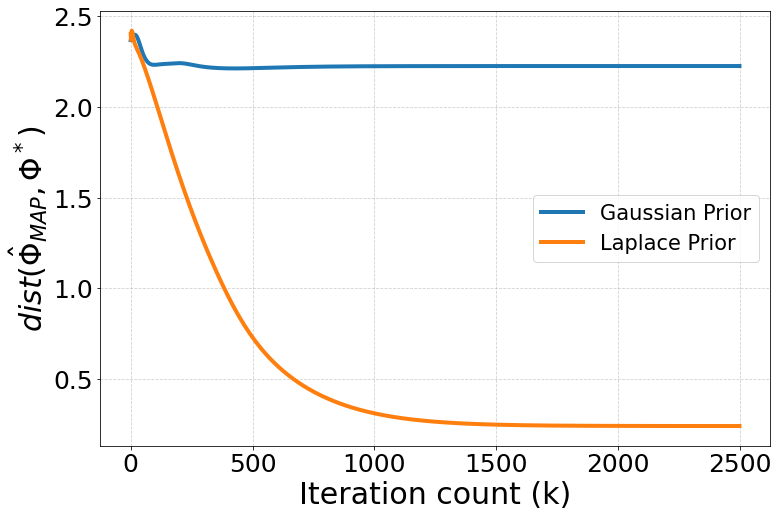

In [78]:
# Create a plot to show the convergence of the Gibbs Sampler (Log-joint vs iterations)
fig, ax = plt.subplots(figsize=(12,8))


# Plot the data
ax.plot(list(range(int(K))), Error_CAMAP_10_Gaussian, label=r'Gaussian Prior', linestyle='-', linewidth=4)
ax.plot(list(range(len(Error_CAMAP_10_Laplace))), Error_CAMAP_10_Laplace, label=r'Laplace Prior', linestyle='-', linewidth=4)


# Set labels and a title
ax.set_xlabel('Iteration count (k)',fontsize=30)
ax.set_ylabel(r'$dist(\hat{\Phi}_{MAP},\Phi^*)$',fontsize=30)
ax.tick_params(axis='both', labelsize=25)
plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:5]  
labels = labels[:5] 
plt.legend(handles=handles, labels=labels,fontsize=21)

# Customize the grid
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()